# Bir Binanın Enerji Verimliliği Tahmini

Veri Seti Bilgileri:

Enerji analizi için Ecotect'te simüle edilen 12 farklı bina şeklini kullanıyoruz. Toplamda 768 binadan oluşan veri seti, her biri 10 değişken içeren bir yapıdadır. Bu değişkenler arasından bağımlı değişkenler olan ısıtma yükünü ve soğutma yükünü tahmin etmeye çalışcağız.

Değişkenler:

- x1 bağıl kompaktlık
- x2 yüzey alanı
- x3 duvar alanı
- x4 çatı alanı
- x5 toplam yükseklik
- x6 yönlendirme
- x7 cam alanı
- x8 cam alanı dağılımı
- y1 Isıtma Yükü
- y2 Soğutma Yükü

# 1. Bölüm: KEŞİFÇİ VERİ ANALİZİ
- Veri Seti Okuma
- Veri Seti Kolon İsimleri
- Veri Seti Kolon İsimlerini Değiştirme
- Veri Setinin Tanımlayıcı istatistiklerinin Transpozu alınmış hali
- Veri Seti Tanımlayıcı İstatistiklerinin Tablo Halinde Verilmesi
- Veri Setinin Genel Resmi
- Veri Setinde Numerik ve Kategorik Değişkenlerin  Yakalanması 
- Kategorik değişkenlerin incelenmesi
- Numeric Değişkenlerin İncelenmesi
- Hedef Değişken Analizi
- Korelasyon Analizi

# 2. Bölüm: ÖZELLİK MÜHENDİSLİĞİ
- Aykırı Değer Analizi
- Eksik Değerler
- Label Encoding
- Özellik Ölçeklendirme(Scale)

# 3. Bölüm: MODELLERİN KURULUMU VE BAŞARILARI

## 1. BÖLÜM
## 1. KEŞİFÇİ VERİ ANALİZİ

### Gerekli Kütüphaneler

In [42]:
import numpy as np# çok boyutlu dizileri ve matrixleri hızlı şekilde kullanma
import pandas as pd # dataframe işlemleri için

import random #sayı üretmek, rastgele seçimler yapmak 

#######veri görselleştirme#########
import matplotlib.pyplot as plt
import seaborn as sns

#######başarı metrikleri için kullanılan kütüphane#########
from math import sqrt
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

#Hiperparameter optimizasyonu kütüphanesi
from sklearn.model_selection import GridSearchCV, cross_validate

#veri setini train şekilde ayırmak için kullandığımız kütüphane
from sklearn.model_selection import train_test_split

#Label_Encoder_islemi
from sklearn.preprocessing import LabelEncoder

#verileri belirli bir ölçekte ayarlamak için kütüphane
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


#Makine Öğrenmesi kütüphaneleri
import joblib #machine learning model kayıt.
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.model_selection import GridSearchCV

### 1.1. Veri Seti okutma

In [43]:
df=pd.read_csv("enerji.csv")
df.drop('Y2', axis=1, inplace=True) # bir kolonu sildik ve kalıcı olarak bıraktık.
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


### 1.2. Veri Seti Kolon İsimlerini Öğrenme

In [44]:
df.columns.to_list()#kolon isimleri

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1']

### 1.3. Veri Setindeki Kolon isimlerini Değiştirme

In [45]:
#değişken(kolon) ismi değiştirme


yeni_isimler = {
    'X1': 'bagil_kompaktlik',
    'X2': 'yuzey_alani',
    'X3': 'duvar_alani',
    'X4': 'cati_alani',
    'X5': 'toplam_yukseklik',
    'X6': 'oryantasyon',
    'X7': 'cam_alani',
    'X8': 'cam_alani_dagilimi',
    'Y1': 'isitma_yuku',
}

df.rename(columns=yeni_isimler, inplace=True)
df.head()

,bagil_kompaktlik,yuzey_alani,duvar_alani,cati_alani,toplam_yukseklik,oryantasyon,cam_alani,cam_alani_dagilimi,isitma_yuku
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


### 1.4. Veri Setinin Tanımlayıcı istatistiklerinin Transpozu alınmış hali

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bagil_kompaktlik,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
yuzey_alani,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
duvar_alani,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
cati_alani,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
toplam_yukseklik,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
oryantasyon,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
cam_alani,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
cam_alani_dagilimi,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
isitma_yuku,768.0,22.307201,10.090196,6.01,12.9925,18.95,31.6675,43.10


### 1.5. Veri Setinin Tanımlayıcı istatistiklerinin tablo halinde verilmiş hali

In [47]:
from tabulate import tabulate
betimsel_istatistikler = df.describe()
table = tabulate(betimsel_istatistikler, headers='keys', tablefmt='fancy_grid',numalign='center',stralign='center')
#table=tabulate(betimsel_istatistikler, headers=, tablefmt, numalign, stralign, missingval)
print(table)

╒═══════╤════════════════════╤═══════════════╤═══════════════╤══════════════╤════════════════════╤═══════════════╤═════════════╤══════════════════════╤═══════════════╕
│       │  bagil_kompaktlik  │  yuzey_alani  │  duvar_alani  │  cati_alani  │  toplam_yukseklik  │  oryantasyon  │  cam_alani  │  cam_alani_dagilimi  │  isitma_yuku  │
╞═══════╪════════════════════╪═══════════════╪═══════════════╪══════════════╪════════════════════╪═══════════════╪═════════════╪══════════════════════╪═══════════════╡
│ count │        768         │      768      │      768      │     768      │        768         │      768      │     768     │         768          │      768      │
├───────┼────────────────────┼───────────────┼───────────────┼──────────────┼────────────────────┼───────────────┼─────────────┼──────────────────────┼───────────────┤
│ mean  │      0.764167      │    671.708    │     318.5     │   176.604    │        5.25        │      3.5      │  0.234375   │        2.8125        │    22.30

### 1.6. Veri Setinin Genel Resmi

In [48]:


def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape) # satır sütun sayısı.
    print("##################### Types #####################")
    print(dataframe.dtypes) # değişkenleri veri tipi
    print("##################### Head #####################")
    print(dataframe.head(head)) # veri setinde ilk 5 değişken
    print("##################### Tail #####################")
    print(dataframe.tail(head))  #veri setinde son 5 satır
    print("##################### NA #####################")
    print(dataframe.isnull().sum()) # Değişkenlerin boş satır sayısı.
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

df.head()
df.info()

##################### Shape #####################
(768, 9)
##################### Types #####################
bagil_kompaktlik      float64
yuzey_alani           float64
duvar_alani           float64
cati_alani            float64
toplam_yukseklik      float64
oryantasyon             int64
cam_alani             float64
cam_alani_dagilimi      int64
isitma_yuku           float64
dtype: object
##################### Head #####################
   bagil_kompaktlik  yuzey_alani  duvar_alani  cati_alani  toplam_yukseklik  \
0              0.98        514.5        294.0      110.25               7.0   
1              0.98        514.5        294.0      110.25               7.0   
2              0.98        514.5        294.0      110.25               7.0   
3              0.98        514.5        294.0      110.25               7.0   
4              0.90        563.5        318.5      122.50               7.0   

   oryantasyon  cam_alani  cam_alani_dagilimi  isitma_yuku  
0            2        

### 1.7. Veri Setinde Numerik ve Kategorik Değişkenlerin  Yakalanması 

In [49]:
##################################
# NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI
##################################

#cat_th= bir numerik değişken ..'dan(aşağıdaki 10 olarak tanımladık örneğin) daha az eşsiz değere sahip ise buna kategorik değişken muamelesi yapıcak.
#car_th= bir kategorik değişken ..'dan aşağıdaki 20 olarak tanımladık örneğin)daha az eşsiz değere sahip ise buna numerik değişken muamelesi yapıcak.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)



Observations: 768
Variables: 9
cat_cols: 6
num_cols: 3
cat_but_car: 0
num_but_cat: 6


### 1.8. kategorik değişkenlerin incelenmesi

In [50]:
cat_cols

['duvar_alani',
 'cati_alani',
 'toplam_yukseklik',
 'oryantasyon',
 'cam_alani',
 'cam_alani_dagilimi']

#### 1.8.1. kategorik değişkenlerin dağılımı

In [51]:
#kategorik değişkenleri dağılımı
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

       duvar_alani      Ratio
294.0          192  25.000000
318.5          192  25.000000
343.0          128  16.666667
416.5           64   8.333333
245.0           64   8.333333
269.5           64   8.333333
367.5           64   8.333333
##########################################


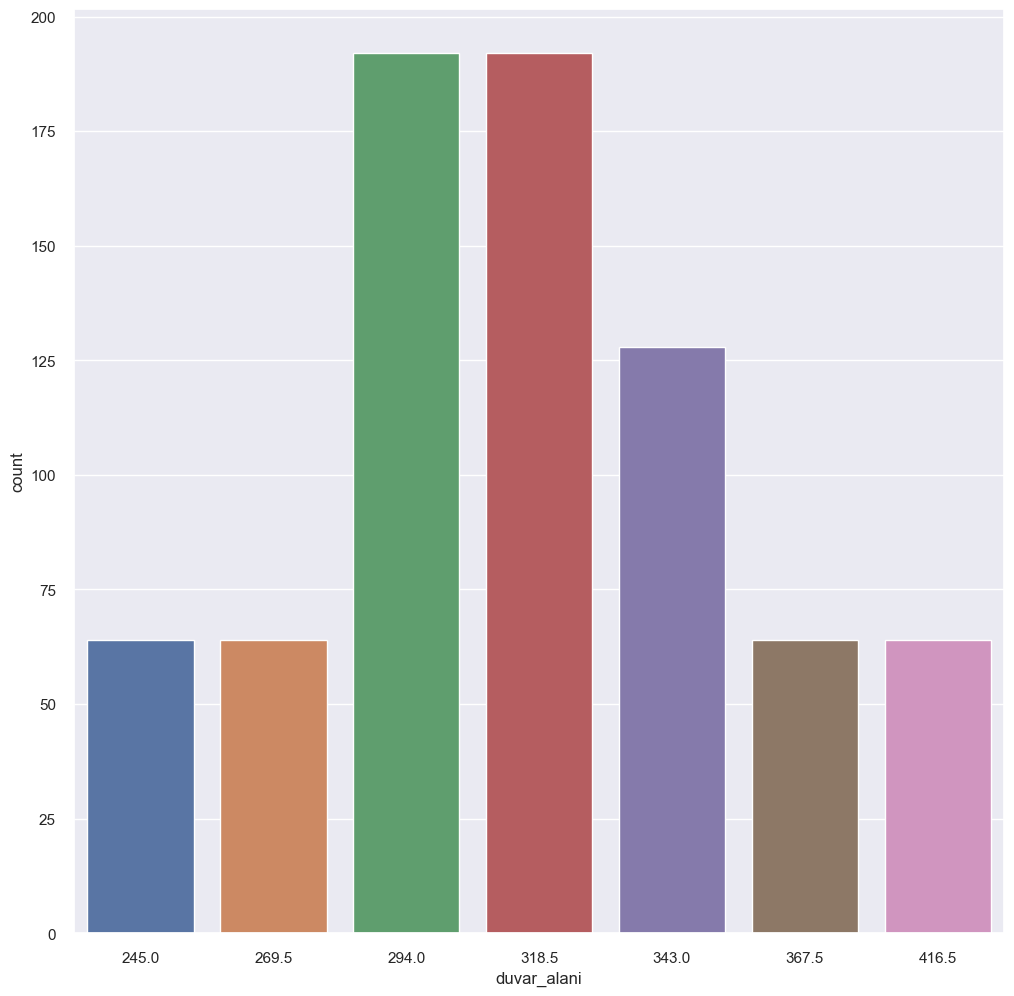

        cati_alani      Ratio
220.50         384  50.000000
147.00         192  25.000000
122.50         128  16.666667
110.25          64   8.333333
##########################################


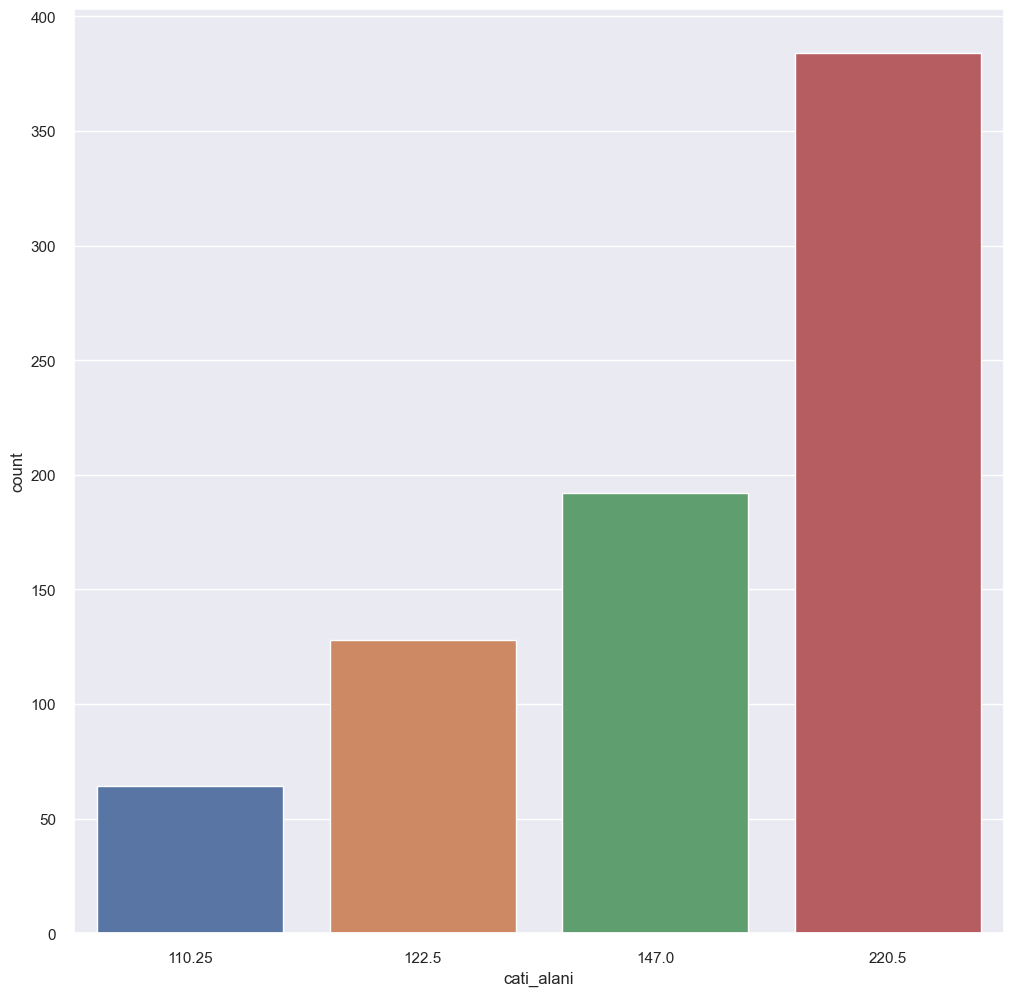

     toplam_yukseklik  Ratio
7.0               384   50.0
3.5               384   50.0
##########################################


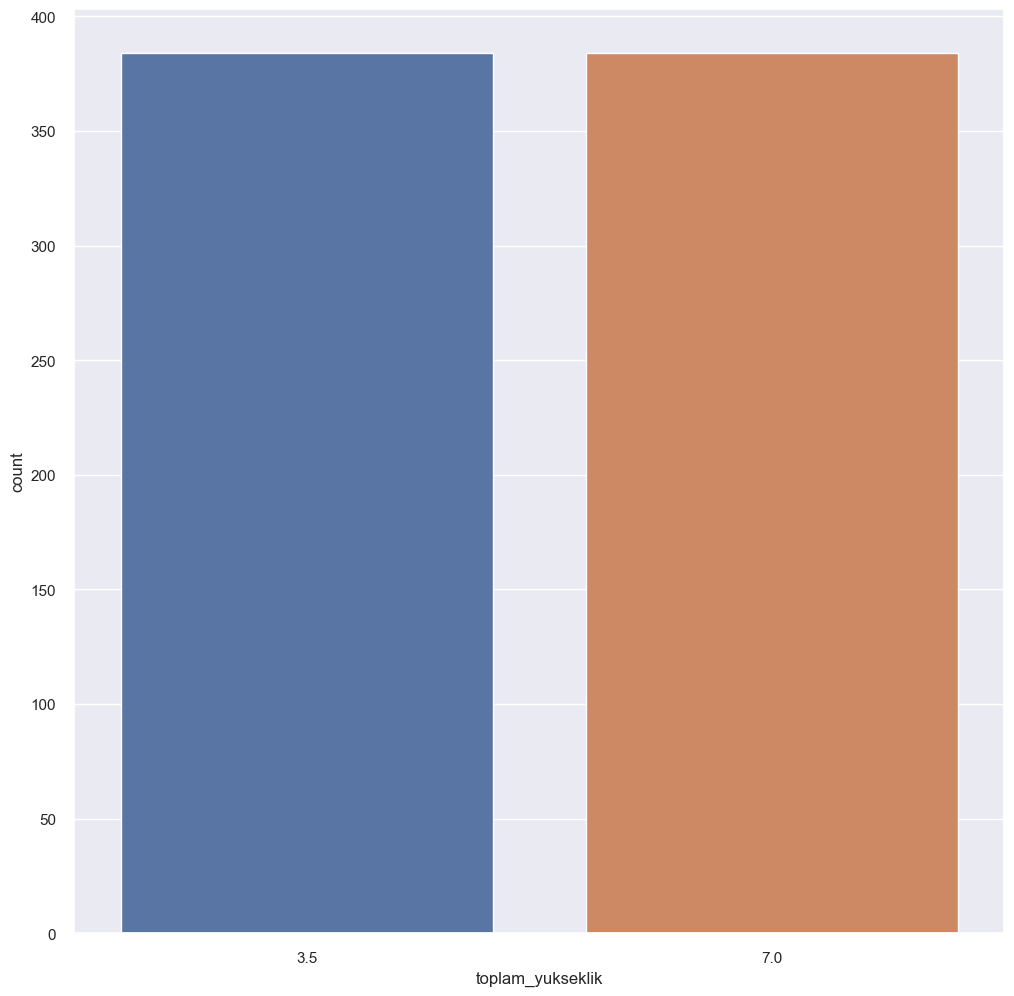

   oryantasyon  Ratio
2          192   25.0
3          192   25.0
4          192   25.0
5          192   25.0
##########################################


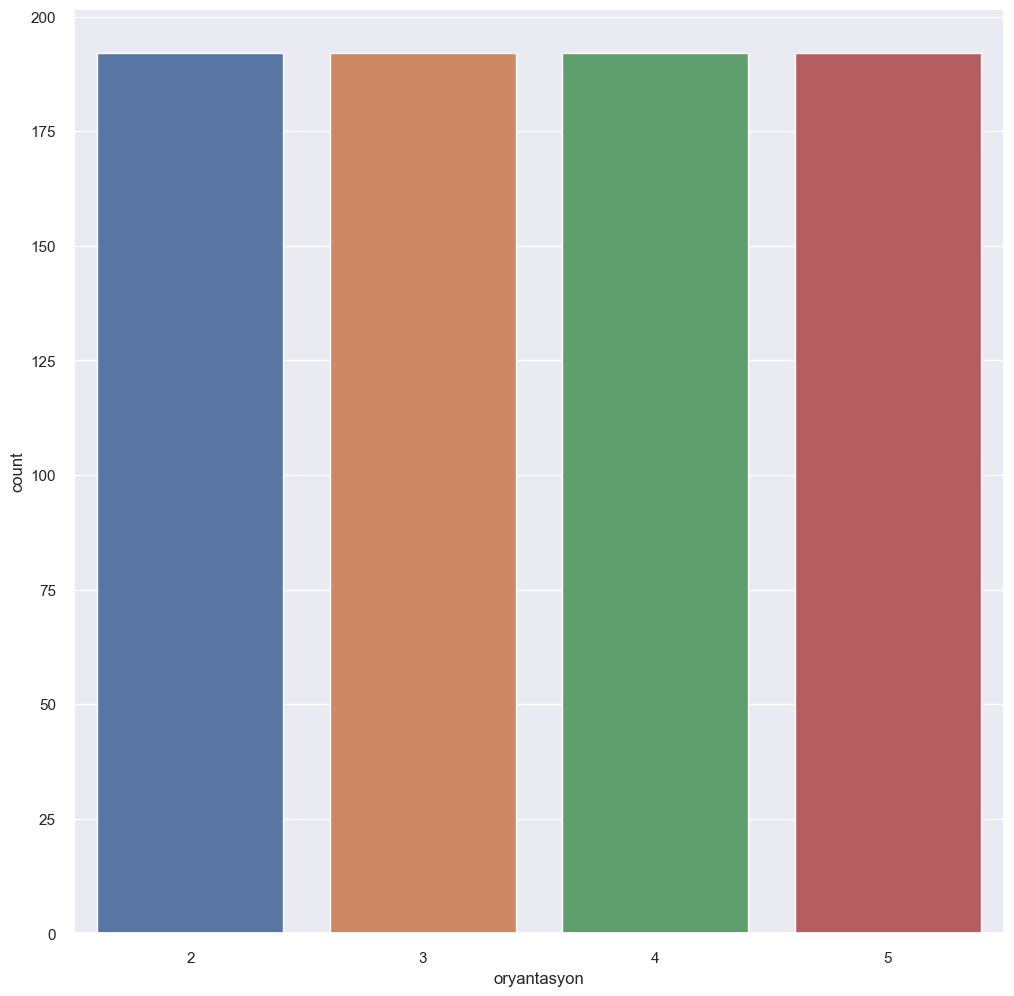

      cam_alani  Ratio
0.10        240  31.25
0.25        240  31.25
0.40        240  31.25
0.00         48   6.25
##########################################


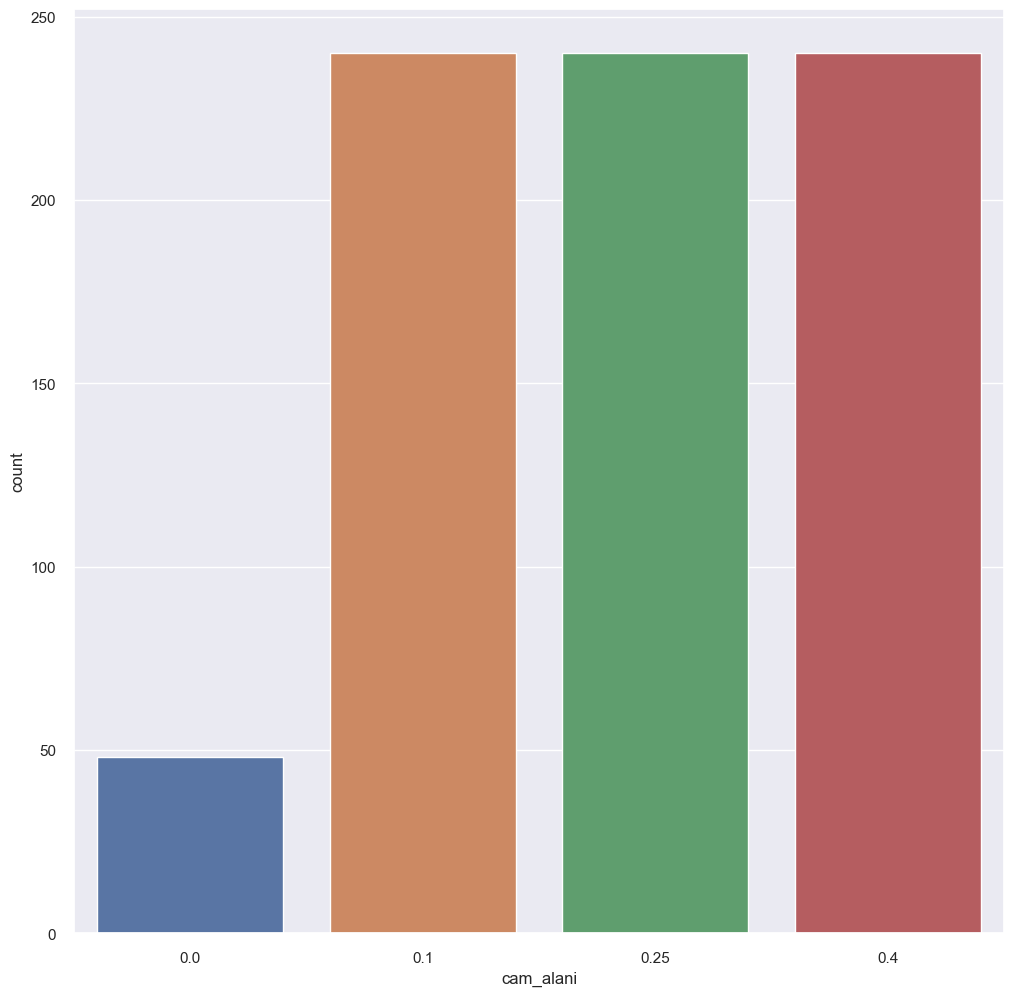

   cam_alani_dagilimi  Ratio
1                 144  18.75
2                 144  18.75
3                 144  18.75
4                 144  18.75
5                 144  18.75
0                  48   6.25
##########################################


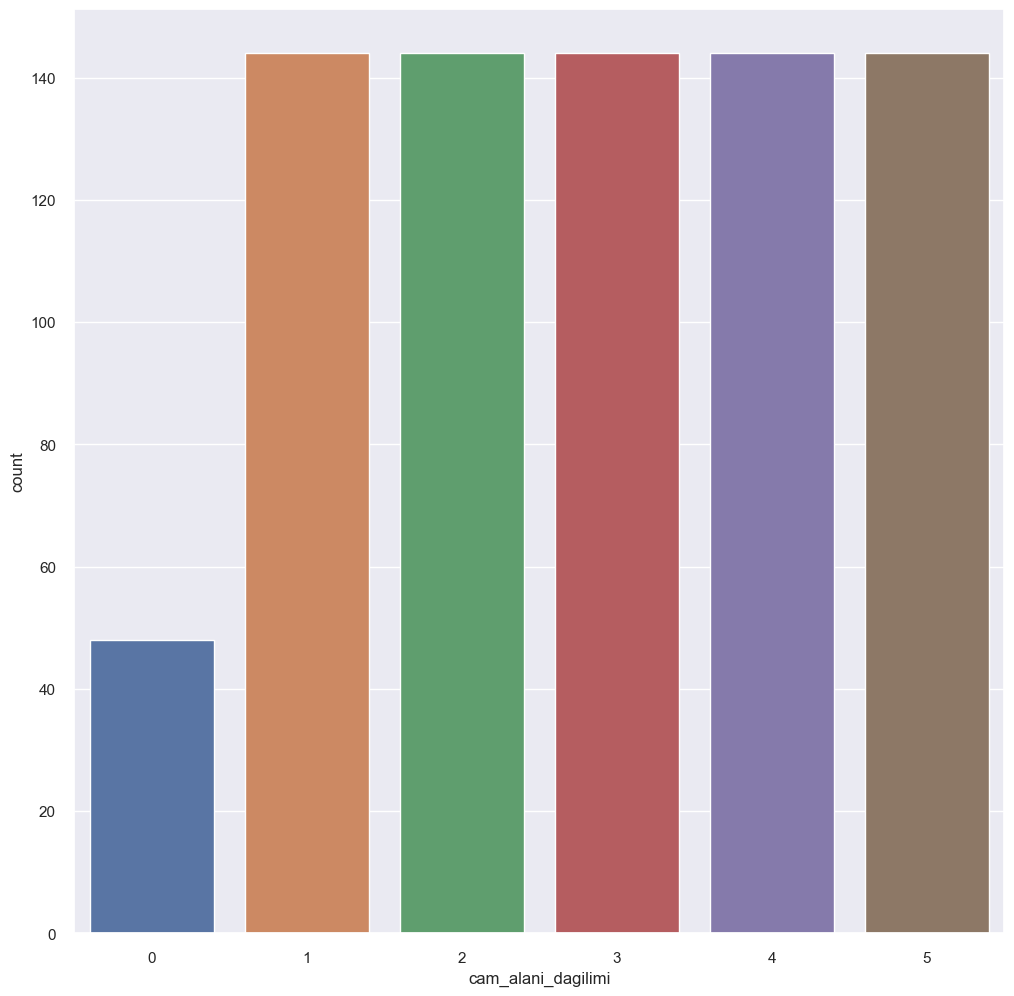

In [52]:
for col in cat_cols:
    cat_summary(df, col)

### 1.9. Numeric Değişkenlerin incelenmesi

In [53]:
num_cols

['bagil_kompaktlik', 'yuzey_alani', 'isitma_yuku']

#### 1.9.1.Numeric değişkenlerin dağılımı

In [54]:
#numeric değişkenlerin dağılımı
def num_summary(dataframe, numerical_col, plot=True):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    768.000000
mean       0.764167
std        0.105777
min        0.620000
5%         0.620000
10%        0.640000
20%        0.660000
30%        0.690000
40%        0.710000
50%        0.750000
60%        0.790000
70%        0.820000
80%        0.860000
90%        0.900000
95%        0.980000
99%        0.980000
max        0.980000
Name: bagil_kompaktlik, dtype: float64


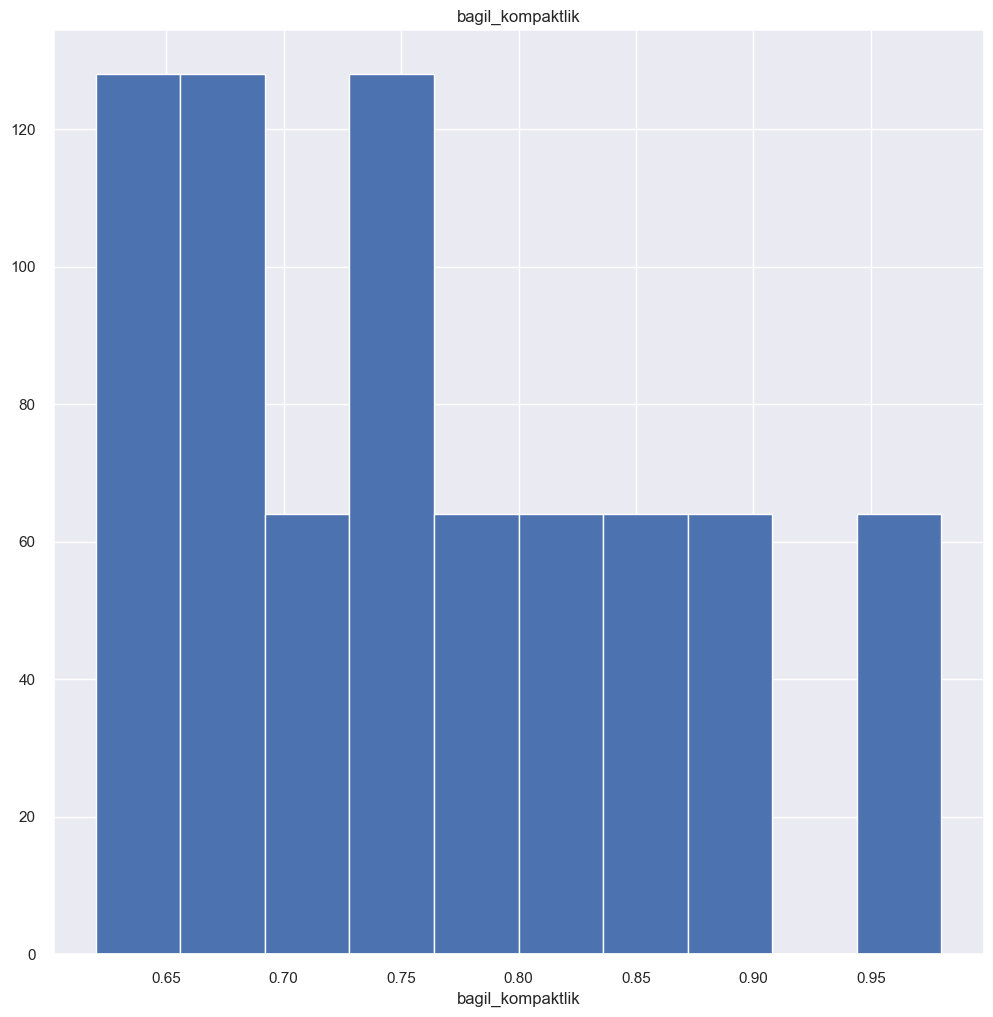

count    768.000000
mean     671.708333
std       88.086116
min      514.500000
5%       514.500000
10%      563.500000
20%      588.000000
30%      612.500000
40%      637.000000
50%      673.750000
60%      710.500000
70%      735.000000
80%      759.500000
90%      784.000000
95%      808.500000
99%      808.500000
max      808.500000
Name: yuzey_alani, dtype: float64


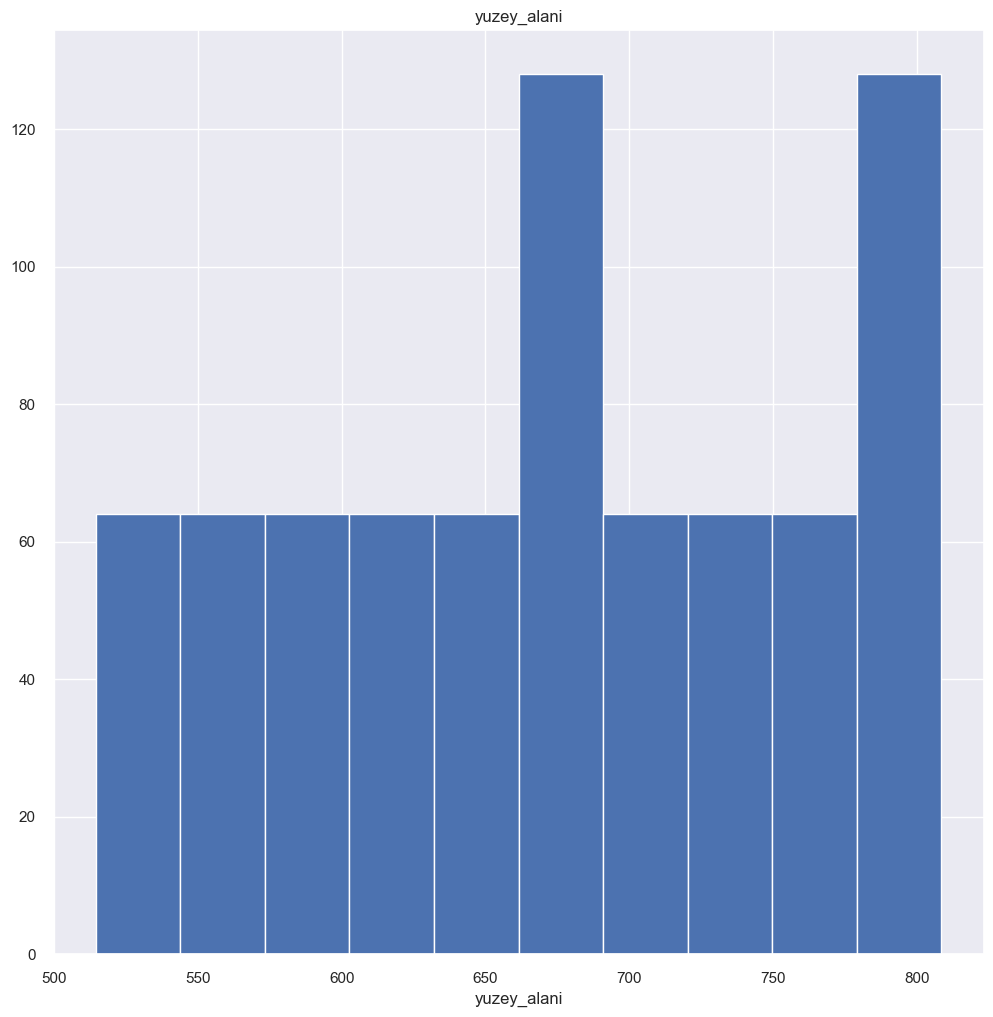

count    768.000000
mean      22.307201
std       10.090196
min        6.010000
5%        10.463500
10%       11.217000
20%       12.630000
30%       14.320000
40%       15.230000
50%       18.950000
60%       25.668000
70%       29.089000
80%       32.508000
90%       36.703000
95%       39.860000
99%       42.089900
max       43.100000
Name: isitma_yuku, dtype: float64


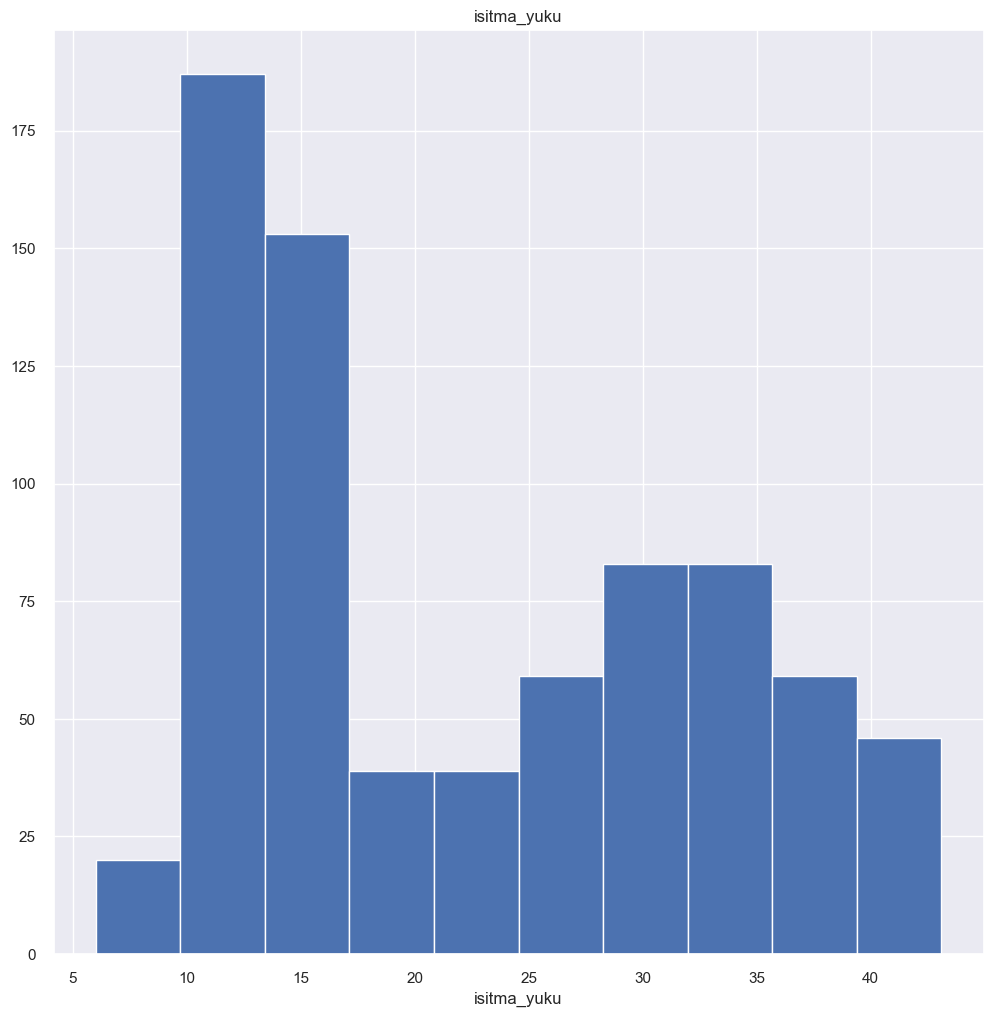

In [55]:
for col in num_cols:
    num_summary(df, col, plot=True)

### 1.10 Hedef Değişken Analizi

In [56]:
df["isitma_yuku"].value_counts()

15.16    6
13.00    5
15.55    4
10.68    4
28.15    4
        ..
10.47    1
33.21    1
36.77    1
36.71    1
16.64    1
Name: isitma_yuku, Length: 586, dtype: int64


#### 10.1.1. Hedef Değişkenin Kategorik Değişkenler ile Analizi


In [57]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


In [58]:
for col in cat_cols:
    target_summary_with_cat(df, "isitma_yuku", col)

             TARGET_MEAN
duvar_alani             
245.0          11.886719
269.5          12.040156
294.0          22.862604
318.5          23.333646
343.0          27.611641
367.5          14.283281
416.5          35.664219


            TARGET_MEAN
cati_alani             
110.25        27.646250
122.50        33.646563
147.00        30.905312
220.50        13.338516


                  TARGET_MEAN
toplam_yukseklik             
3.5                 13.338516
7.0                 31.275885


             TARGET_MEAN
oryantasyon             
2              22.312865
3              22.380677
4              22.259896
5              22.275365


           TARGET_MEAN
cam_alani             
0.00         14.286458
0.10         20.357167
0.25         22.756917
0.40         25.411667


                    TARGET_MEAN
cam_alani_dagilimi             
0                     14.286458
1                     23.026111
2                     22.934444
3                     22.681458
4                    


#### 10.1.2. Hedef Değişkenin Numerik Değişkenler ile Analizi


In [59]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [60]:
for col in num_cols:
    target_summary_with_num(df, "isitma_yuku", col)



             bagil_kompaktlik
isitma_yuku                  
6.01                     0.74
6.04                     0.74
6.05                     0.74
6.07                     0.74
6.37                     0.71
...                       ...
42.62                    0.79
42.74                    0.79
42.77                    0.79
42.96                    0.79
43.10                    0.79

[586 rows x 1 columns]


             yuzey_alani
isitma_yuku             
6.01               686.0
6.04               686.0
6.05               686.0
6.07               686.0
6.37               710.5
...                  ...
42.62              637.0
42.74              637.0
42.77              637.0
42.96              637.0
43.10              637.0

[586 rows x 1 columns]


             isitma_yuku
isitma_yuku             
6.01                6.01
6.04                6.04
6.05                6.05
6.07                6.07
6.37                6.37
...                  ...
42.62              42.62
42.74   

### 1.11.Korelasyon analizi

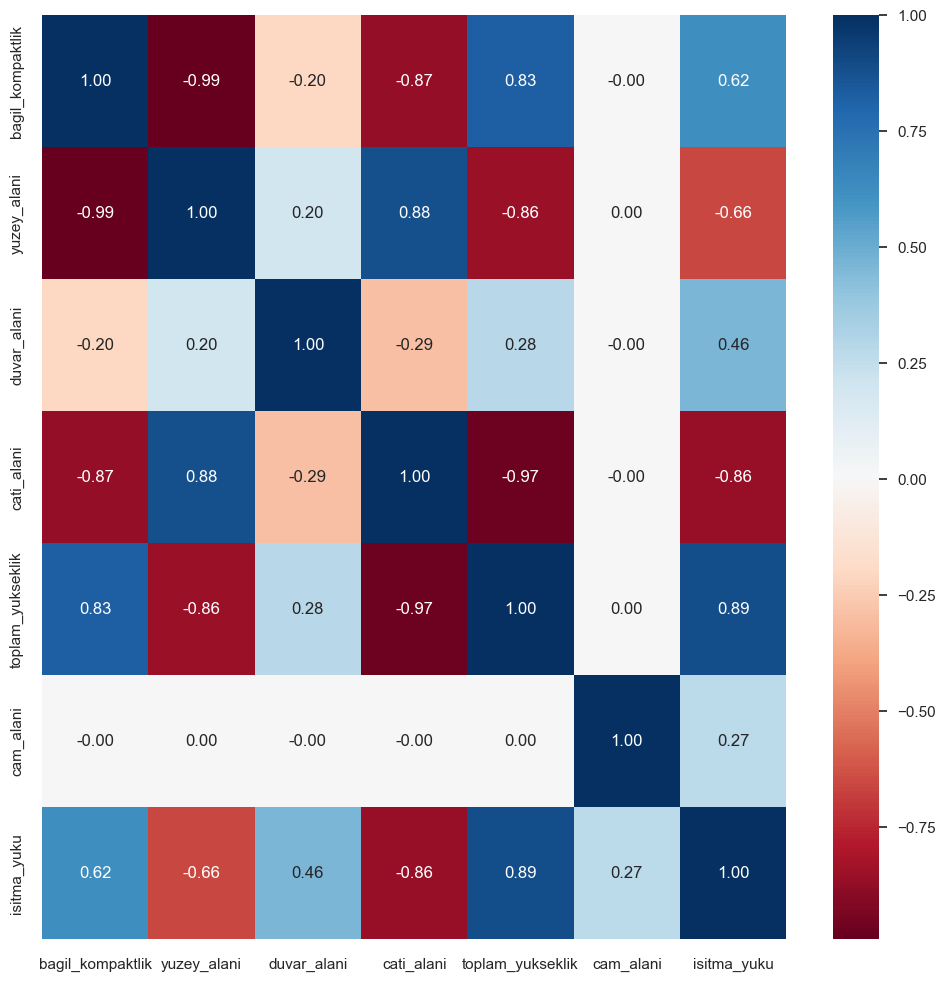

In [61]:

num_cols = [col for col in df.columns if df[col].dtype in [int, float]]

corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")
plt.show()


####  1.11.1. Korelasyon Analizi Matris Tablosu

In [62]:
#korelasyon matrisi tablosu
cor_matrix = df.corr().abs()
cor_matrix

,bagil_kompaktlik,yuzey_alani,duvar_alani,cati_alani,toplam_yukseklik,oryantasyon,cam_alani,cam_alani_dagilimi,isitma_yuku
bagil_kompaktlik,1.000000e+00,9.919015e-01,2.037817e-01,8.688234e-01,8.277473e-01,4.678592e-17,2.960552e-15,7.107006e-16,0.622272
yuzey_alani,9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,8.581477e-01,3.459372e-17,3.636925e-15,2.438409e-15,0.658120
duvar_alani,2.037817e-01,1.955016e-01,1.000000e+00,2.923165e-01,2.809757e-01,2.429499e-17,8.567455e-17,2.067384e-16,0.455671
cati_alani,8.688234e-01,8.807195e-01,2.923165e-01,1.000000e+00,9.725122e-01,5.830058e-17,1.759011e-15,1.078071e-15,0.861828
toplam_yukseklik,8.277473e-01,8.581477e-01,2.809757e-01,9.725122e-01,1.000000e+00,4.492205e-17,1.489134e-17,2.920613e-17,0.889431
oryantasyon,4.678592e-17,3.459372e-17,2.429499e-17,5.830058e-17,4.492205e-17,1.000000e+00,9.406007e-16,2.549352e-16,0.002587
cam_alani,2.960552e-15,3.636925e-15,8.567455e-17,1.759011e-15,1.489134e-17,9.406007e-16,1.000000e+00,2.129642e-01,0.269841
cam_alani_dagilimi,7.107006e-16,2.438409e-15,2.067384e-16,1.078071e-15,2.920613e-17,2.549352e-16,2.129642e-01,1.000000e+00,0.087368
isitma_yuku,6.222722e-01,6.581202e-01,4.556712e-01,8.618283e-01,8.894307e-01,2.586534e-03,2.698410e-01,8.736759e-02,1.000000


#### 1.11.2. Korelasyon analizi matris tab 2

In [63]:
upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
upper_triangle_matrix

,bagil_kompaktlik,yuzey_alani,duvar_alani,cati_alani,toplam_yukseklik,oryantasyon,cam_alani,cam_alani_dagilimi,isitma_yuku
bagil_kompaktlik,NaN,0.991901,0.203782,0.868823,0.827747,4.678592e-17,2.960552e-15,7.107006e-16,0.622272
yuzey_alani,NaN,NaN,0.195502,0.880720,0.858148,3.459372e-17,3.636925e-15,2.438409e-15,0.658120
duvar_alani,NaN,NaN,NaN,0.292316,0.280976,2.429499e-17,8.567455e-17,2.067384e-16,0.455671
cati_alani,NaN,NaN,NaN,NaN,0.972512,5.830058e-17,1.759011e-15,1.078071e-15,0.861828
toplam_yukseklik,NaN,NaN,NaN,NaN,NaN,4.492205e-17,1.489134e-17,2.920613e-17,0.889431
oryantasyon,NaN,NaN,NaN,NaN,NaN,NaN,9.406007e-16,2.549352e-16,0.002587
cam_alani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.129642e-01,0.269841
cam_alani_dagilimi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087368
isitma_yuku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Bölüm

## 2. Feature Enginerring

### 2.1. Aykırı Değer Analizi

#### 2.1.1. Boxplot yöntemi(IQR Fonksiyonu tanımlama)

In [64]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#### 2.1.2. IQR Alt ve Üst Limitlerini Belirleme

In [65]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


#### 2.1.3. Aykırı Değeri Olan Değişkenler

In [66]:
for col in num_cols:
    print(col, check_outlier(df, col))

bagil_kompaktlik False
yuzey_alani False
duvar_alani False
cati_alani False
toplam_yukseklik False
cam_alani False
isitma_yuku False


### 2.2. Eksik Değerler(Missing Value)

In [67]:
df.isnull().values.any()

False

In [68]:
df.isnull().sum().sum()# eksik veri sayısı

0

eksik verimiz yok.

### 2.3. Encoding

In [69]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]


one_hot_encoder(df, ohe_cols).head()

,bagil_kompaktlik,yuzey_alani,toplam_yukseklik,isitma_yuku,duvar_alani_269.5,duvar_alani_294.0,duvar_alani_318.5,duvar_alani_343.0,duvar_alani_367.5,duvar_alani_416.5,...,oryantasyon_4,oryantasyon_5,cam_alani_0.1,cam_alani_0.25,cam_alani_0.4,cam_alani_dagilimi_1,cam_alani_dagilimi_2,cam_alani_dagilimi_3,cam_alani_dagilimi_4,cam_alani_dagilimi_5
0,0.98,514.5,7.0,15.55,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.98,514.5,7.0,15.55,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.98,514.5,7.0,15.55,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.98,514.5,7.0,15.55,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.90,563.5,7.0,20.84,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.4. Özellik Ölçeklendirme(Scale)

In [70]:
y = df["isitma_yuku"]
X = df.drop(["isitma_yuku"], axis=1)

In [71]:
y.head()

0    15.55
1    15.55
2    15.55
3    15.55
4    20.84
Name: isitma_yuku, dtype: float64

In [72]:
scaler= RobustScaler()
df[X.columns.to_list()]=scaler.fit_transform(df[X.columns.to_list()])

In [73]:
df.head()

,bagil_kompaktlik,yuzey_alani,duvar_alani,cati_alani,toplam_yukseklik,oryantasyon,cam_alani,cam_alani_dagilimi,isitma_yuku
0,1.559322,-1.181818,-0.5,-0.923077,0.5,-1.000000,-0.833333,-1.333333,15.55
1,1.559322,-1.181818,-0.5,-0.923077,0.5,-0.333333,-0.833333,-1.333333,15.55
2,1.559322,-1.181818,-0.5,-0.923077,0.5,0.333333,-0.833333,-1.333333,15.55
3,1.559322,-1.181818,-0.5,-0.923077,0.5,1.000000,-0.833333,-1.333333,15.55
4,1.016949,-0.818182,0.0,-0.769231,0.5,-1.000000,-0.833333,-1.333333,20.84


## 3. BÖLÜM

## 3. MODELLERİN KURULUMU VE EĞİTİMİ

### 3.1. Eğitim - Validation - Test olarak ayrılması

In [75]:
from sklearn.model_selection import train_test_split

# Veri setini train ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=17)

# Kalan veri setini validation ve test setlerine ayırma
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17)


In [76]:
X_train.head()

,bagil_kompaktlik,yuzey_alani,duvar_alani,cati_alani,toplam_yukseklik,oryantasyon,cam_alani,cam_alani_dagilimi
679,0.90,563.5,318.5,122.5,7.0,5,0.40,4
134,0.66,759.5,318.5,220.5,3.5,4,0.10,2
250,0.86,588.0,294.0,147.0,7.0,4,0.10,5
470,0.66,759.5,318.5,220.5,3.5,4,0.25,4
668,0.62,808.5,367.5,220.5,3.5,2,0.40,3


In [77]:
X_train.count()

bagil_kompaktlik      614
yuzey_alani           614
duvar_alani           614
cati_alani            614
toplam_yukseklik      614
oryantasyon           614
cam_alani             614
cam_alani_dagilimi    614
dtype: int64

In [78]:
X_test.count()

bagil_kompaktlik      77
yuzey_alani           77
duvar_alani           77
cati_alani            77
toplam_yukseklik      77
oryantasyon           77
cam_alani             77
cam_alani_dagilimi    77
dtype: int64

### 3.2. Base Modellerin kurulumu

In [79]:
def base_models_regression(X, y, scoring="neg_mean_squared_error"):
    print("Base Models for Regression....")
    regressors = [('Linear Regression', LinearRegression()),
                  ("SVR", SVR()),
                  ("Decision Tree", DecisionTreeRegressor()),
                  ("Random Forest", RandomForestRegressor()),
                  ('Adaboost Regressor', AdaBoostRegressor()),
                  ('Gradient Boosting Regressor', GradientBoostingRegressor()),
                  ('XGBoost Regressor', XGBRegressor(use_label_encoder=False, eval_metric='logloss')),
                  ('LightGBM Regressor', LGBMRegressor())]

    for name, regressor in regressors:
        cv_results = cross_validate(regressor, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(np.abs(cv_results['test_score'].mean()), 4)} ({name}) ")

# Örnek kullanım:
# base_models_regression(X_reg, y_reg, scoring="neg_mean_squared_error")


In [80]:
base_models_regression(X_train, y_train, scoring="neg_mean_squared_error")

Base Models for Regression....
neg_mean_squared_error: 9.425 (Linear Regression) 
neg_mean_squared_error: 39.0207 (SVR) 
neg_mean_squared_error: 0.4035 (Decision Tree) 
neg_mean_squared_error: 0.3327 (Random Forest) 
neg_mean_squared_error: 3.5043 (Adaboost Regressor) 
neg_mean_squared_error: 0.2492 (Gradient Boosting Regressor) 
neg_mean_squared_error: 0.1932 (XGBoost Regressor) 
neg_mean_squared_error: 0.3298 (LightGBM Regressor) 


### 3.3. Hiperparametre Optimizasyonu

In [81]:

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

regressors = [("Decision Tree", DecisionTreeRegressor(), cart_params),
               ("Random Forest", RandomForestRegressor(), rf_params),
               ('XGBoost Regressor', XGBRegressor(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM Regressor', LGBMRegressor(), lightgbm_params)]

In [82]:
from sklearn.model_selection import GridSearchCV
def hyperparameter_optimization(X, y, cv=3, scoring="neg_mean_squared_error"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, regressor, params in regressors:
        print(f"########## {name} ##########")
        cv_results = cross_validate(regressor, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(regressor, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = regressor.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [84]:
best_models=hyperparameter_optimization(X_train,y_train)

Hyperparameter Optimization....
########## Decision Tree ##########
neg_mean_squared_error (Before): -0.364
neg_mean_squared_error (After): -0.3633
Decision Tree best params: {'max_depth': 7, 'min_samples_split': 4}

########## Random Forest ##########
neg_mean_squared_error (Before): -0.8642
neg_mean_squared_error (After): -0.8309
Random Forest best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost Regressor ##########
neg_mean_squared_error (Before): -0.1762
neg_mean_squared_error (After): -0.1762
XGBoost Regressor best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM Regressor ##########
neg_mean_squared_error (Before): -0.2252
neg_mean_squared_error (After): -0.2252
LightGBM Regressor best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 500}



### 3.4. En iyi Modellerin Karmasından Oluşturulan Model

In [94]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

def voting_regressor(best_models, X, y):
    print("Voting Regressor...")
    voting_reg = VotingRegressor(estimators=[('Decision Tree', best_models["Decision Tree"]), ('Random Fores', best_models["Random Forest"]),
                                             ('LightGBM Regressor', best_models["LightGBM Regressor"])],
                                 n_jobs=-1).fit(X, y)
    
    cv_results = cross_validate(voting_reg, X, y, cv=3, scoring="neg_mean_squared_error")
    
    neg_mse_mean = -cv_results['test_score'].mean()
    
    print(f"Negative Mean Squared Error: {neg_mse_mean}")
    
    return voting_reg

In [86]:
best_models

{'Decision Tree': DecisionTreeRegressor(max_depth=7, min_samples_split=4),
 'Random Forest': RandomForestRegressor(max_features=5, min_samples_split=15, n_estimators=200),
 'XGBoost Regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'LightGBM Regressor': LGBMRegressor(colsample_bytree=0.

In [87]:
voting_reg=voting_regressor(best_models,X_train,y_train)

Voting Regressor...
Negative Mean Squared Error: 0.30176178905167905


### 3.5. En Başarılı Modelde Hata Oranı

In [88]:
train_pred=voting_reg.predict(X_train)
val_pred=voting_reg.predict(X_validation)
test_pred=voting_reg.predict(X_test)

In [89]:
def calculate_rmse_for_custom_splits(y_true_train, y_pred_train,y_true_val, y_pred_val, y_true_test, y_pred_test):
    """
    Verilen gerçek ve tahmin edilen değerler için RMSE hesaplar.

    Parameters:
    - y_true_train: Eğitim setindeki gerçek değerler
    - y_pred_train: Eğitim setindeki tahmin edilen değerler
    - y_true_val: Doğrulama setindeki gerçek değerler
    - y_pred_val: Doğrulama setindeki tahmin edilen değerler
    - y_true_test: Test setindeki gerçek değerler
    - y_pred_test: Test setindeki tahmin edilen değerler

    Returns:
    - train_rmse: Eğitim seti RMSE
    - val_rmse: Doğrulama seti RMSE
    - test_rmse: Test seti RMSE
    """

    # Eğitim setinde RMSE hesapla
    train_rmse = sqrt(mean_squared_error(y_true_train, y_pred_train))

    # Doğrulama setinde RMSE hesapla
    val_rmse = sqrt(mean_squared_error(y_true_val, y_pred_val))

    # Test setinde RMSE hesapla
    test_rmse = sqrt(mean_squared_error(y_true_test, y_pred_test))

    print(f"Train RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Test RMSE: {test_rmse}")

In [90]:
calculate_rmse_for_custom_splits(y_train, train_pred,y_validation, val_pred, y_test, test_pred)

Train RMSE: 0.3467118367305679
Validation RMSE: 0.4283289649245472
Test RMSE: 0.3665326592630858


### 3.6. Model Kayıt

In [91]:
joblib.dump(voting_reg, "vot ing_clf2.pkl")

['vot ing_clf2.pkl']

### 3.7. Model Çağırma

In [92]:
random_user = X.sample(1, random_state=45)
new_model = joblib.load("voting_clf2.pkl")
new_model.predict(random_user)


array([24.40102776])